# Exploratory data analysis

In [39]:
import pandas as pd  
import numpy as np
import warnings 
import math
warnings.simplefilter('ignore')
import sklearn 
import seaborn as sns
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

import matplotlib.pyplot as plt

# import custom functions
import sys
sys.path.append("../")
import mcc_metastasis.data_cleaning as dc

## open data
### 1. NCDB with full feature set

In [40]:
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv")
# select only features for analysis
df = df[['metastasis', 'TNM_positive', 'AGE', 'tumor_size', 'tumor_depth', 'tumor_site', 'SEX', 
               'tumor_lymphocytes', 'lymph_vasc_invasion', 'immuno_suppressed']]
df_complete = df.dropna(axis = 0)
df.head()

,metastasis,TNM_positive,AGE,tumor_size,tumor_depth,tumor_site,SEX,tumor_lymphocytes,lymph_vasc_invasion,immuno_suppressed
0,NaN,NaN,90,NaN,NaN,trunk,0,NaN,NaN,NaN
1,0.0,0.0,71,1.0,NaN,head_neck,1,NaN,0.0,NaN
2,1.0,NaN,87,NaN,NaN,extremity,1,NaN,NaN,NaN
3,0.0,0.0,43,0.2,0.1,other,1,0.0,NaN,0.0
4,NaN,NaN,81,NaN,NaN,other,1,NaN,NaN,NaN


In [41]:
print("Number of  records: {}".format(df.shape[0]))
print("Number of complete records: {}".format(df_complete.shape[0]))

print("Number of variables: {}".format(df.shape[1]))

Number of  records: 14948
Number of complete records: 629
Number of variables: 10


In [42]:
dc.get_missingness_table(df)

Missingness of features


,index,Missing
0,metastasis,3572
1,TNM_positive,8747
2,AGE,0
3,tumor_size,4041
4,tumor_depth,11488
5,tumor_site,0
6,SEX,0
7,tumor_lymphocytes,12260
8,lymph_vasc_invasion,10026
9,immuno_suppressed,10311


## Compare outcome variables 
### with full dataset
- TNM positive is missing 3403 cases that are positive in metastasis variable
- huge difference in the ratio of positive to negative between variables.

In [43]:
# TNM is missing 3K values that we do have for mets
dc.get_N_table(df, ['metastasis', 'TNM_positive'])

,metastasis,TNM_positive,N
0,0.0,0.0,4366
1,0.0,1.0,2
2,0.0,NaN,2874
3,1.0,0.0,28
4,1.0,1.0,1140
5,1.0,NaN,2966
6,NaN,0.0,649
7,NaN,1.0,16
8,NaN,NaN,2907


In [44]:
display(dc.get_N_table(df, ['metastasis']))
display(dc.get_N_table(df, ['TNM_positive']))

,metastasis,N
0,0.0,7242
1,1.0,4134
2,NaN,3572


,TNM_positive,N
0,0.0,5043
1,1.0,1158
2,NaN,8747


### with complete dataset
- mostly 99% match

In [45]:
dc.get_N_table(df_complete, ['metastasis', 'TNM_positive'])

,metastasis,TNM_positive,N
0,0.0,0.0,450
1,0.0,1.0,1
2,1.0,0.0,2
3,1.0,1.0,176


## Explore features and outcome

### Location of the tumor

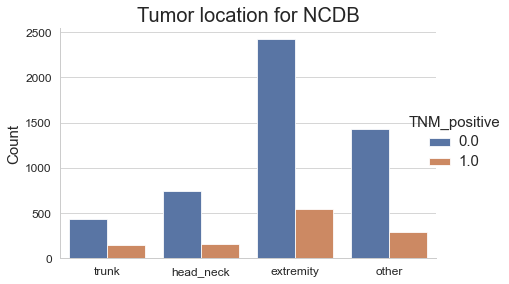

In [46]:
g = sns.catplot(data = df, x ="tumor_site" , kind = "count",
                     hue = "TNM_positive" , height = 4, aspect = 1.5)
plt.xlabel( "", size =  15)
plt.ylabel ("Count",  size = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.setp(g._legend.get_title(), fontsize = 15)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.title("Tumor location for NCDB", fontsize = 20)
plt.savefig('../figures/TNM_positive_tumor_location.png', bbox_inches = 'tight')

### Tumor size

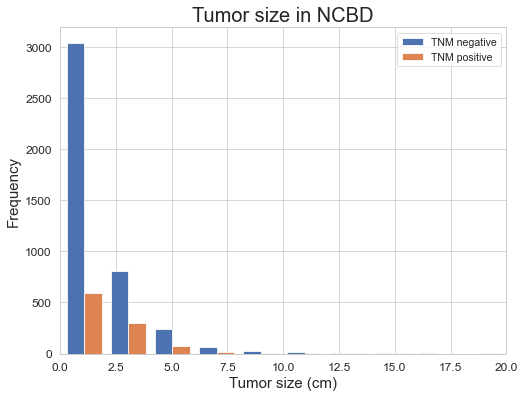

In [47]:
group1 =  df.tumor_size[df.TNM_positive == 0]
group2 = df.tumor_size[df.TNM_positive == 1]

plt.figure(figsize = (8, 6))
plt.hist([group1, group2],
        bins = 50, label = ["TNM negative","TNM positive"])
plt.legend(loc = 'upper right')
plt.xlabel("Tumor size (cm)", size =  15)
plt.ylabel ("Frequency",  size = 15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlim(0, 20)
plt.title("Tumor size in NCBD", size = 20)
plt.savefig('../figures/tumor_size_TNM_positive.png', bbox_inches = 'tight')
plt.show()


### tumor depth

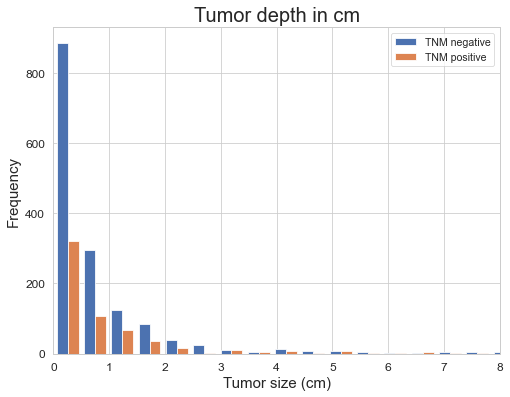

In [51]:
group1 =  df.tumor_depth[df.TNM_positive == 0]
group2 = df.tumor_depth[df.TNM_positive == 1]

plt.figure(figsize = (8, 6))
plt.hist([group1, group2],
        bins = 20, label = ["TNM negative","TNM positive"])
plt.legend(loc = 'upper right')
plt.xlabel("Tumor size (cm)", size =  15)
plt.ylabel ("Frequency",  size = 15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlim(0, 8)
plt.title("Tumor depth in cm", size = 20)
plt.savefig('../figures/tumor_depth_TNM_positive.png', bbox_inches = 'tight')
plt.show()


## Demographics
### Age

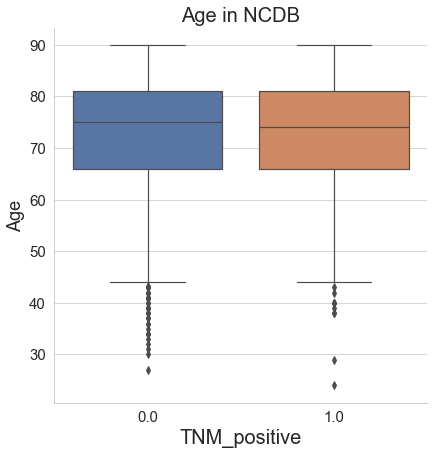

In [52]:
g= sns.catplot(data = df,
                     x = "TNM_positive", y = "AGE", kind = "box",
                      height = 6)
plt.xlabel("TNM_positive", size =  20)
plt.ylabel ("Age",  size = 18)
plt.title("Age in NCDB", size =  20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('../figures/age_and_TNM_positive.png', bbox_inches = 'tight')


In [53]:
g= sns.catplot(data = df,  x = "Sex", kind = "count",
                     hue = "TNM_positive", height = 6)
plt.xlabel("", size =  20)
plt.ylabel ("Count",  size = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Sex in NCDB", size = 20)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.savefig('../figures/sex_and_TNM_positive.png', bbox_inches = 'tight')

ValueError: Could not interpret input 'Sex'

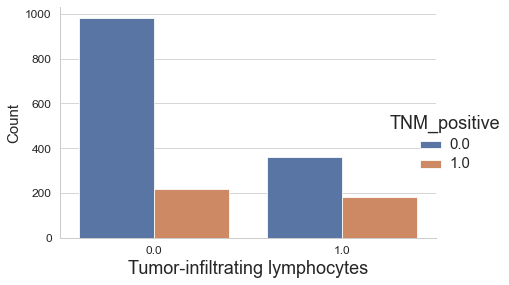

In [54]:
g= sns.catplot(data = df, 
                     x = "tumor_lymphocytes", kind = "count",
                     hue = "TNM_positive", height = 4, aspect = 1.5 )
plt.xlabel("Tumor-infiltrating lymphocytes", size = 18)
plt.ylabel ("Count",  size = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.savefig('../figures/tumor_lymphocytes_TNM_positive.png', bbox_inches = 'tight')


### Lymphnode vascular invasion
Indicates the presence or absence of tumor cells in lymphatic channels (not lymph nodes) or blood vessels within the primary tumor as noted microscopically by the pathologist.

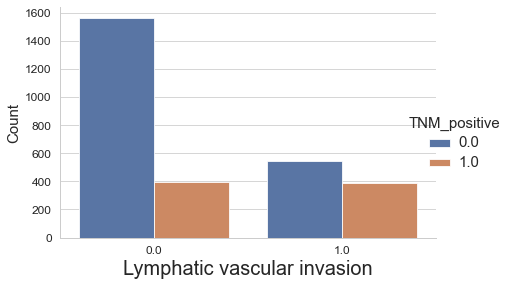

In [55]:
g= sns.catplot(data = df, x = "lymph_vasc_invasion", kind = "count",
                     hue = "TNM_positive", height = 4, aspect = 1.5)
plt.xlabel("Lymphatic vascular invasion", size =  20)
plt.ylabel ("Count",  size = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.setp(g._legend.get_title(), fontsize = 15)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.savefig('../figures/tumor_lymph_vasc_invasion_TNM_positive.png', bbox_inches = 'tight')


### Immunosuppressed

e.g. HIV/AIDS, leukemia, lymphoma


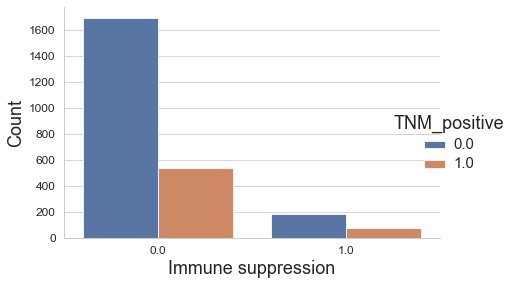

In [56]:
g= sns.catplot(data = df,  x = "immuno_suppressed", kind = "count",
                     hue = "TNM_positive", height = 4, aspect = 1.5)
plt.xlabel("Immune suppression", size = 18)
plt.ylabel ("Count",  size = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.savefig('../figures/immuno_suppression_TNM_positive.png', bbox_inches = 'tight')


### correlation between depth and size 
- they are correlated, and tumor size is always reported, so we'll use that.

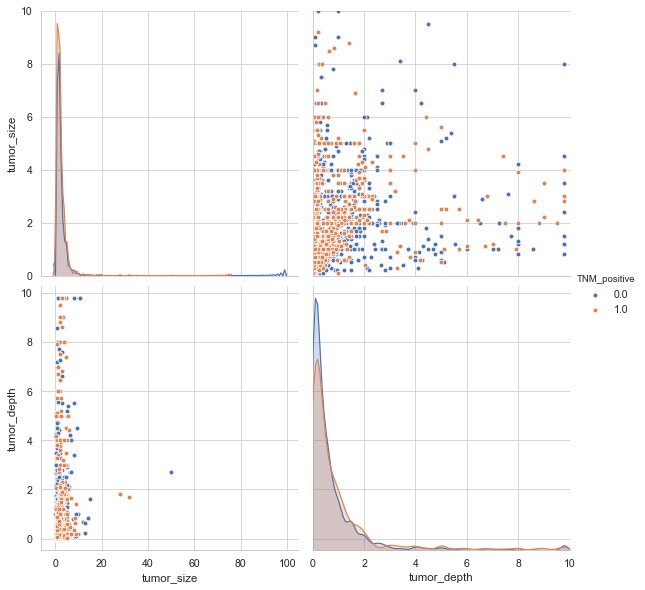

In [67]:
g = sns.pairplot(data = df[['tumor_size', 'tumor_depth', 'TNM_positive']],
             hue = "TNM_positive",  height = 4)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.savefig('../figures/tumor_size_vs_dept_TNM_positive.png', bbox_inches = 'tight')


In [66]:
from scipy.stats import pearsonr
pearsonr(df_complete.tumor_size, df_complete.tumor_depth)

(0.15947897185316048, 5.8819642011353504e-05)